# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,col
from pyspark.sql.types import IntegerType

import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_data = "mini_sparkify_event_data.json"
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.


In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [7]:
# number of records
df.count()

286500

In [8]:
# the number of users in the dataset
df.select("userId").distinct().count()

226

In [6]:
df.groupBy("auth").count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+



In [6]:
df.groupBy("level").count().show()

+-----+------+
|level| count|
+-----+------+
| free| 58338|
| paid|228162|
+-----+------+



In [24]:
df.select('page','status')\
  .groupBy('page','status')\
  .count().show()

+--------------------+------+-----+
|                page|status|count|
+--------------------+------+-----+
| Submit Registration|   307|    5|
|           Downgrade|   200| 2055|
|       Save Settings|   307|  310|
|                Help|   200| 1726|
|Cancellation Conf...|   200|   52|
|            Settings|   200| 1514|
|          Add Friend|   307| 4277|
|             Upgrade|   200|  499|
|         Roll Advert|   200| 3933|
|      Submit Upgrade|   307|  159|
|               Error|   404|  258|
|                Home|   200|14457|
|               About|   200|  924|
|               Login|   307| 3241|
|     Add to Playlist|   200| 6526|
|              Logout|   307| 3226|
|         Thumbs Down|   307| 2546|
|              Cancel|   307|   52|
|            Register|   200|   18|
|           Thumbs Up|   307|12551|
+--------------------+------+-----+
only showing top 20 rows



From the result above, `Cancel` should be a prompt notification page, and those who successfully canceled the services may be directed to the `Cancellation Confirmation` page.

In [16]:
df.groupBy("method").count().show()

+------+------+
|method| count|
+------+------+
|   PUT|261064|
|   GET| 25436|
+------+------+




### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


In [11]:
from pyspark.sql.functions import col

churn_fun = udf(lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())
downgrade_fun = udf(lambda x: 1 if x=="Downgrade" else 0, IntegerType())

df = df.withColumn("Churn",churn_fun("page"))
df = df.withColumn("DownGrade",downgrade_fun("page"))
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+---------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|DownGrade|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+---------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|        0|
|    Five Iron Frenzy|Logged

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [20]:
# Drop useless features
df_simple = df.drop("firstName","lastName","artist","song","method","status")

In [21]:
df_simple.head()

Row(auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', registration=1538173362000, sessionId=29, status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0, DownGrade=0)

#### Page uses

In [32]:
# page frequency
pages = df.select('page').groupby('page').count().toPandas().sort_values(by='count',ascending=False)
pages['proportion']=pages['count']/pages['count'].sum()*100

In [33]:
pages.head()

,page,count,proportion
16,NextSong,228108,79.618848
3,Home,14457,5.046073
17,Thumbs Up,12551,4.380803
14,Add to Playlist,6526,2.277836
15,Add Friend,4277,1.492845


<function matplotlib.pyplot.show(close=None, block=None)>

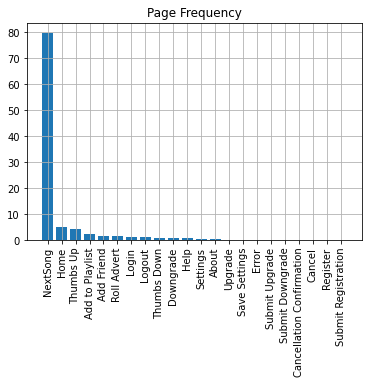

In [37]:
plt.bar(pages['page'],pages['proportion'])
plt.title("Page Frequency")
plt.xticks(rotation=90)
plt.grid()
plt.show

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.